### Ising Model Generative
(Written by Debayan Dasgupta)

A Work in progress to create a generative model based on Ising Model. 2D Ising models show phase transitions and are incredibly good at creating clumpy islands. 2D Ising models are used to study the evolution of domains of ferromagnetic materials. I believe this is the ideal model to use to generate creatures in cellular automata. The goal is to have AI generate structures (imagine gliders, oscillators and spaceships in Conway's Game of Life). 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


I am using the same Ising Model class written in this github project(https://github.com/CorySimon/IsingModel)
At some point this needs to be rewritten in pytorch to allow the autograd to work well. For the time being we'll work with a 2D rectangular grid with periodic boundary conditions.

In [2]:
class IsingGrid:
    def __init__(self, height, width, extfield, invtemp):
        self.width, self.height, self.extfield, self.invtemp = height, width, extfield, invtemp
        self.grid = np.zeros([self.width, self.height], dtype=np.int8) + 1
        
    def plot(self):
        plt.imshow(self.grid, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
    
    def make_random(self):
        self.grid = (np.random.randint(0, 2, size = self.width * self.height).reshape(self.width, self.height) * 2) - 1
    
    def neighbours(self, x, y):
        n = []
        if x == 0:
            n.append( (self.width-1, y) )
        else:
            n.append( (x-1, y) )
        if x == self.width-1:
            n.append( (0, y) )
        else:
            n.append( (x+1, y) )
        if y == 0:
            n.append( (x, self.height-1) )
        else:
            n.append( (x, y-1) )
        if y == self.height-1:
            n.append( (x, 0) )
        else:
            n.append( (x, y+1) )
        return n
    
    def local_energy(self, x, y):
        return self.extfield + sum( self.grid[xx,yy] for (xx, yy) in self.neighbours(x, y) )
    
    def total_energy(self):
        # Could maybe do some numpy games here, but periodic boundary conditions make this tricky.
        # This function is only ever useful for very small grids anyway.
        energy = - self.extfield * np.sum(self.grid)
        energy += - sum( self.grid[x, y] * sum( self.grid[xx, yy] for (xx, yy) in self.neighbours(x, y) )
                        for x in range(self.width) for y in range(self.height) ) / 2
        return energy
    
    def probability(self):
        return np.exp( - self.invtemp * self.total_energy() )
    
    def gibbs_move(self):
        n = np.random.randint(0, self.width * self.height)
        y = n // self.width
        x = n % self.width
        p = 1 / (1 + np.exp(-2 * self.invtemp * self.local_energy(x,y)))
        if np.random.random() <= p:
            self.grid[x,y] = 1
        else:
            self.grid[x,y] = -1
            
    def from_number(self, n):
        """Convert an integer 0 <= n < 2**(width*height) into a grid."""
        binstring = bin(n)[2:]
        binstring = "0" * (N - len(binstring)) + binstring
        self.grid = np.array([int(x)*2-1 for x in binstring], dtype=np.int8).reshape(self.width, self.height)
    
    def to_number(self):
        """Convert grid into an integer."""
        flat = [self.grid[x, y] for x in range(self.width) for y in range(self.height)]
        return sum(2**n * (int(x)+1)//2 for n, x in enumerate(reversed(flat)))

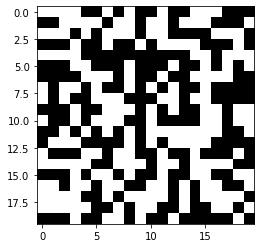

In [3]:
gg = IsingGrid(20, 20, 0, .3)
gg.make_random()
gg.plot()

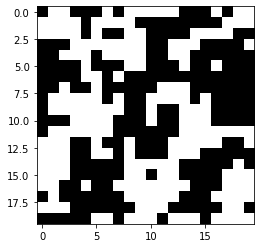

In [4]:
for _ in range(100000):
    gg.gibbs_move()
gg.plot()

# Denoising and loss function
We are testing a custom loss function defined by the algo:

$argmax({Train \ast Train}) - argmax({Train \ast Generated})$

This is implemented below in the $c\_loss$ function

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
grid_size = 50
n_steps = 100

# Model
Testing a very simple model. Complexity will be added later.

In [7]:
import torch.nn.functional as F
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(grid_size, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, grid_size)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)


In [8]:

model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


#### Loss function

In [9]:
#self_convolve

def c_loss(model,dataset):
    #output = model(dataset,torch.tensor([0])).floor()+(model(dataset,torch.tensor([0])).floor()+1)
    output = model(dataset,torch.tensor([0]))
    orig = F.conv2d(dataset.reshape(1,1,grid_size,grid_size),dataset.reshape(1,1,grid_size,grid_size))
    test = F.conv2d(output.reshape(1,1,grid_size,grid_size),dataset.reshape(1,1,grid_size,grid_size))
    #torch.max(self_colvolve) - torch.max(gen_colvolve)
    return abs(orig - test)


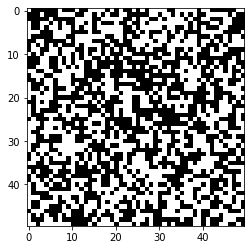

In [10]:
gg = IsingGrid(grid_size, grid_size, 0, .3)
gg.make_random()
gg.plot()
#convert gg.grid to tensor
dataset = torch.Tensor(gg.grid).float()


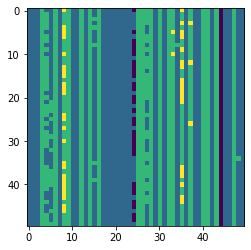

In [11]:
gg.make_random()
dataset = torch.Tensor(gg.grid).float()

out = model(dataset,torch.tensor([0])).floor()+(model(dataset,torch.tensor([0])).floor()+1)
plt.imshow(out.detach().numpy())

for i in range(10000):
    
    # Compute the loss of the model from this batch
    loss = c_loss(model, dataset)

    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()

    # Perform gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)

    # Calling the step function to update the parameters
    optimizer.step()


In [12]:
out = model(dataset,torch.tensor([0])).floor()+(model(dataset,torch.tensor([0])).floor()+1)

(out/out.max()).floor().detach().numpy()

array([[-1., -1., -1., ...,  0.,  0., -1.],
       [-1., -1., -1., ...,  0.,  0., -1.],
       [-1., -1., -1., ...,  0.,  0., -1.],
       ...,
       [-1., -1., -1., ...,  0.,  0., -1.],
       [-1., -1., -1., ...,  0.,  0., -1.],
       [-1., -1., -1., ...,  0.,  0., -1.]], dtype=float32)